In [1]:
## BaarleNet [Part 7 - save intermediate weights].ipynb

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

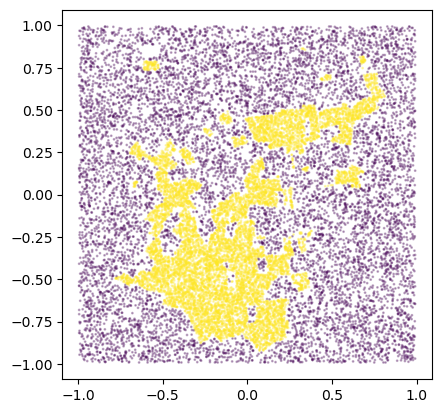

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

In [5]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
import pickle
import copy
import os

In [8]:
# Assuming X and y are already defined
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Training parameters
num_epochs = 2500
num_seeds = 32

# Configure output directory
output_dir = "/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_training_weights_1"  # Change this to your desired directory
os.makedirs(output_dir, exist_ok=True)
print(f"Saving results to: {output_dir}")

for seed_idx in range(num_seeds):
    random_seed = seed_idx  # You can change this to any seed generation logic
    torch.manual_seed(random_seed)
    
    # Initialize model and optimizer
    model = BaarleNet([3])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Data storage for this run
    training_data = {
        'seed': random_seed,
        'weights_history': [],
        'gradients_history': [],
        'xy_history': [],
        'loss_history': [],
        'accuracy_history': []
    }
    
    print(f"\n=== Training with seed {random_seed} ===")
    
    for epoch in range(num_epochs):
        # Get current data point
        current_idx = epoch % len(y)
        current_x = torch.tensor(X[current_idx]).float()
        current_y = torch.tensor(y[current_idx])
        
        # Forward pass
        outputs = model(current_x)
        loss = criterion(outputs, current_y)
        
        # Store current X,y values
        training_data['xy_history'].append({
            'epoch': epoch,
            'x': X[current_idx].copy(),
            'y': y[current_idx]
        })
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Store model weights (deep copy to avoid reference issues)
        current_weights = {}
        for name, param in model.named_parameters():
            current_weights[name] = param.data.clone()
        training_data['weights_history'].append(current_weights)
        
        # Store model gradients (deep copy)
        current_gradients = {}
        for name, param in model.named_parameters():
            if param.grad is not None:
                current_gradients[name] = param.grad.clone()
            else:
                current_gradients[name] = None
        training_data['gradients_history'].append(current_gradients)
        
        # Update parameters
        optimizer.step()
        
        # Store loss
        training_data['loss_history'].append(loss.item())
        
        # Calculate and store accuracy periodically
        if (epoch + 1) % (num_epochs // 25) == 0:
            with torch.no_grad():
                outputs_batch = model(X_tensor)
                accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
                training_data['accuracy_history'].append({
                    'epoch': epoch,
                    'accuracy': accuracy
                })
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
    # Calculate final accuracy
    with torch.no_grad():
        final_outputs = model(X_tensor)
        final_accuracy = (torch.argmax(final_outputs, dim=1) == y_tensor).sum().item() / len(y)
    
    # Save data as pickle file
    filename = os.path.join(output_dir, f"training_data_seed_{random_seed:02d}_acc_{final_accuracy:.4f}.pkl")
    
    # Add final accuracy to the data
    training_data['final_accuracy'] = final_accuracy
    training_data['final_model_state'] = model.state_dict()
    
    with open(filename, 'wb') as f:
        pickle.dump(training_data, f)
    
    print(f"Saved training data to {filename}")
    print(f"Final accuracy: {final_accuracy:.4f}")


Saving results to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_training_weights_1

=== Training with seed 0 ===
Epoch [100/2500], Loss: 0.5847, Accuracy: 0.6047
Epoch [200/2500], Loss: 1.0200, Accuracy: 0.6193
Epoch [300/2500], Loss: 0.6844, Accuracy: 0.6147
Epoch [400/2500], Loss: 0.3945, Accuracy: 0.6203
Epoch [500/2500], Loss: 0.7969, Accuracy: 0.6757
Epoch [600/2500], Loss: 1.3299, Accuracy: 0.6577
Epoch [700/2500], Loss: 0.5322, Accuracy: 0.6561
Epoch [800/2500], Loss: 0.9636, Accuracy: 0.6903
Epoch [900/2500], Loss: 1.3089, Accuracy: 0.6612
Epoch [1000/2500], Loss: 0.3379, Accuracy: 0.7312
Epoch [1100/2500], Loss: 0.0755, Accuracy: 0.7135
Epoch [1200/2500], Loss: 0.8209, Accuracy: 0.7444
Epoch [1300/2500], Loss: 0.8070, Accuracy: 0.7561
Epoch [1400/2500], Loss: 0.3147, Accuracy: 0.7737
Epoch [1500/2500], Loss: 0.3663, Accuracy: 0.7684
Epoch [1600/2500], Loss: 0.2493, Accuracy: 0.7298
Epoch [1700/2500], Loss: 0.6487, Accuracy: 0.7623
Epoch [1800/2500], Loss

In [13]:
# random_seed=0 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
# torch.manual_seed(random_seed)  

# X_tensor = torch.FloatTensor(X)
# y_tensor = torch.tensor(y)

# # Initialize model and optimizer
# model = BaarleNet([2])
# criterion = nn.CrossEntropyLoss()
# # optimizer = optim.SGD(model.parameters(), lr=0.25)
# optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

# num_epochs = 2500
# for epoch in range(num_epochs):

#     outputs = model(torch.tensor(X[epoch%len(y)]).float())
#     loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
#     optimizer.zero_grad()
#     loss.backward()
    
#     optimizer.step()
#     if (epoch+1) % (num_epochs//25) == 0:
#         outputs_batch = model(X_tensor)
#         accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [100/2500], Loss: 0.5027, Accuracy: 0.5592
Epoch [200/2500], Loss: 0.6604, Accuracy: 0.5866
Epoch [300/2500], Loss: 0.3639, Accuracy: 0.6165
Epoch [400/2500], Loss: 0.5104, Accuracy: 0.6021
Epoch [500/2500], Loss: 0.8830, Accuracy: 0.6015
Epoch [600/2500], Loss: 0.4999, Accuracy: 0.6201
Epoch [700/2500], Loss: 0.4561, Accuracy: 0.6241
Epoch [800/2500], Loss: 0.6695, Accuracy: 0.5986
Epoch [900/2500], Loss: 0.3245, Accuracy: 0.5976
Epoch [1000/2500], Loss: 0.5006, Accuracy: 0.6529
Epoch [1100/2500], Loss: 0.3110, Accuracy: 0.6497
Epoch [1200/2500], Loss: 0.5023, Accuracy: 0.6171
Epoch [1300/2500], Loss: 0.6864, Accuracy: 0.6249
Epoch [1400/2500], Loss: 0.1131, Accuracy: 0.6413
Epoch [1500/2500], Loss: 1.0399, Accuracy: 0.6498
Epoch [1600/2500], Loss: 0.1165, Accuracy: 0.6521
Epoch [1700/2500], Loss: 0.9192, Accuracy: 0.6430
Epoch [1800/2500], Loss: 1.8811, Accuracy: 0.6278
Epoch [1900/2500], Loss: 0.6570, Accuracy: 0.6535
Epoch [2000/2500], Loss: 0.9242, Accuracy: 0.6545
Epoch [21

In [14]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

In [15]:
h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

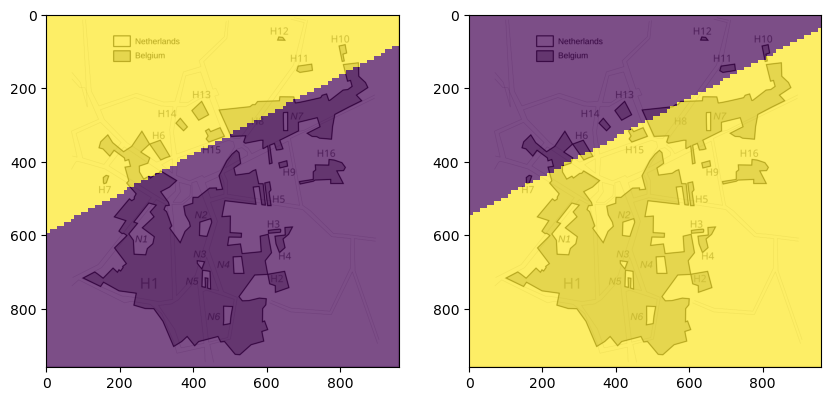

In [16]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')